In [27]:
import geopandas as gpd
from scipy.spatial.distance import cdist
import numpy as np
import math
import matplotlib.pyplot as plt

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.indicators.hv import Hypervolume
plt.rcParams['font.family'] = 'Arial'

Read data

In [2]:
cook_centroids = gpd.read_file('data/cook_centroids_all.shp')
n1 = cook_centroids.shape[0]
cook_centroids.columns, n1

(Index(['GISJOIN', 'Lon_w', 'Lat_w', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID',
        'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
        'INTPTLON', 'Shape_Leng', 'Shape_Area', 'ORIG_FID', 'YEAR', 'STUSAB',
        'REGIONA', 'DIVISIONA', 'STATE', 'STATEA', 'COUNTY', 'COUNTYA',
        'COUSUBA', 'PLACEA', 'TRACTA', 'BLKGRP', 'CONCITA', 'AIANHHA',
        'RES_ONLYA', 'TRUSTA', 'AIHHTLI', 'AITSA', 'ANRCA', 'CBSAA', 'CSAA',
        'METDIVA', 'NECTAA', 'CNECTAA', 'NECTADIVA', 'UAA', 'CDCURRA', 'SLDUA',
        'SLDLA', 'ZCTA5A', 'SUBMCDA', 'SDELMA', 'SDSECA', 'SDUNIA', 'PCI',
        'PUMAA', 'GEO_ID', 'BTTRA', 'BTBG', 'TL_GEO_ID', 'NAME_E', 'NAME_M',
        'S1', 'S2', 'A1', 'A2', 'A3', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7',
        'HHI1', 'HHI2', 'HHI3', 'Total_Pop', 'Total_HH', 'geometry'],
       dtype='object'),
 1331)

User-defined parameters

In [3]:
p = 100
s = 1000
t = 2

Distance matrix

In [4]:
points = cook_centroids['geometry'].apply(lambda geom: (geom.x, geom.y)).tolist()
D = cdist(points, points, metric='euclidean')
D, D.shape

(array([[    0.        ,  1082.87422978,   661.44521516, ...,
         19026.12158013, 19802.36119962, 26772.50604907],
        [ 1082.87422978,     0.        ,   671.36097906, ...,
         18306.97279514, 18782.33657054, 26010.24087613],
        [  661.44521516,   671.36097906,     0.        , ...,
         18377.69148671, 19431.02947413, 26118.43883191],
        ...,
        [19026.12158013, 18306.97279514, 18377.69148671, ...,
             0.        , 21225.23955835,  7820.49208496],
        [19802.36119962, 18782.33657054, 19431.02947413, ...,
         21225.23955835,     0.        , 25218.70463641],
        [26772.50604907, 26010.24087613, 26118.43883191, ...,
          7820.49208496, 25218.70463641,     0.        ]]),
 (1331, 1331))

Coverage

In [5]:
# discrete
A = np.zeros((n1, n1))
for i in range(n1):
    for j in range(n1):
        if D[i, j] <= s:
            A[i, j] = 1
A, A.shape

(array([[1., 0., 1., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 (1331, 1331))

In [6]:
# continuous
A = np.zeros((n1, n1))
for i in range(n1):
    for j in range(n1):
        A[i, j] = math.exp(-t * D[i, j] / s)
A, A.shape

(array([[1.00000000e+00, 1.14664081e-01, 2.66364281e-01, ...,
         2.97934483e-17, 6.30794074e-18, 5.56796777e-24],
        [1.14664081e-01, 1.00000000e+00, 2.61133905e-01, ...,
         1.25535186e-16, 4.85142967e-17, 2.55735977e-23],
        [2.66364281e-01, 2.61133905e-01, 1.00000000e+00, ...,
         1.08978291e-16, 1.32562975e-17, 2.05973941e-23],
        ...,
        [2.97934483e-17, 1.25535186e-16, 1.08978291e-16, ...,
         1.00000000e+00, 3.66430121e-19, 1.61141308e-07],
        [6.30794074e-18, 4.85142967e-17, 1.32562975e-17, ...,
         3.66430121e-19, 1.00000000e+00, 1.24540748e-22],
        [5.56796777e-24, 2.55735977e-23, 2.05973941e-23, ...,
         1.61141308e-07, 1.24540748e-22, 1.00000000e+00]]),
 (1331, 1331))

Demand

In [9]:
groups = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6']
# groups = ['S1', 'S2']
n2 = len(groups)
W = cook_centroids[groups].to_numpy()

MOO-theil

In [10]:
class MCLPE3(ElementwiseProblem):
    def __init__(self, w, a, p):
        super().__init__(n_var=a.shape[1], n_obj=2, n_ieq_constr=1, xl=0, xu=1, vtype=bool)
        self.w = w
        self.a = a
        self.p = p

    def _evaluate(self, x, out, *args, **kwargs):
        y = np.max(x * self.a, axis=1)

        # Objective 1
        obj1 = np.sum(np.sum(y * self.w.T, axis=1))

        # # Objective 2
        u_k = np.sum(y * self.w.T, axis=1) / np.sum(self.w, axis=0)
        u_bar = np.mean(u_k)
        obj2 = 1 / self.w.shape[1] * np.sum(u_k / u_bar * np.log(u_k / u_bar))

        constr = np.sum(x) - self.p  # Constraint on the total number of facilities

        out["F"] = [-obj1, obj2]
        out["G"] = [constr]

problem = MCLPE3(W, A, p)

algorithm = NSGA2(
    pop_size=100,
    sampling=BinaryRandomSampling(),
    crossover=TwoPointCrossover(),
    mutation=BitflipMutation(),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 1000)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

F = [res.F]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  5.160000E+02 |  5.641100E+02 |             - |             -
     2 |      200 |      1 |  5.100000E+02 |  5.424300E+02 |             - |             -
     3 |      300 |      1 |  5.060000E+02 |  5.305400E+02 |             - |             -
     4 |      400 |      1 |  5.010000E+02 |  5.212900E+02 |             - |             -
     5 |      500 |      1 |  4.880000E+02 |  5.116500E+02 |             - |             -
     6 |      600 |      1 |  4.840000E+02 |  5.026400E+02 |             - |             -
     7 |      700 |      1 |  4.780000E+02 |  4.946500E+02 |             - |             -
     8 |      800 |      1 |  4.720000E+02 |  4.876100E+02 |             - |             -
     9 |      900 |      1 |  4.630000E+02 |  4.811700E+02 |             - |             -
    10 |     1000 |      1 |  4.630000E+02 |  4.754000E+02 |             - |             -

In [14]:
n_evals = [algo.evaluator.n_eval for algo in res.history]
hist_F = []
hist_cv = []
hist_cv_avg = []

for algo in res.history:
    opt = algo.opt
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

k = np.where(np.array(hist_cv_avg) <= 0.0)[0].min()
print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")

Whole population feasible in Generation 286 after 28700 evaluations.


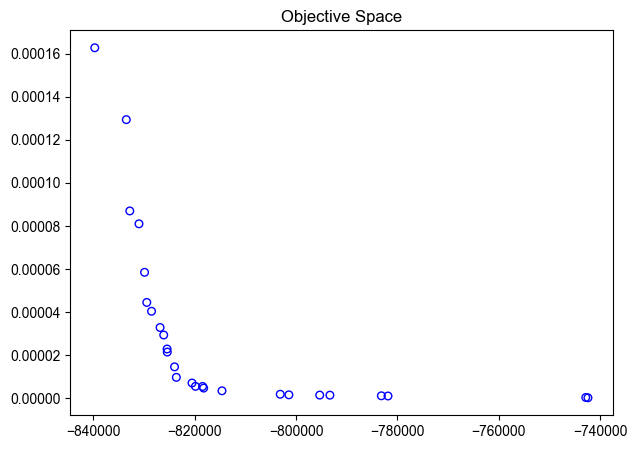

In [34]:
F = res.F
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

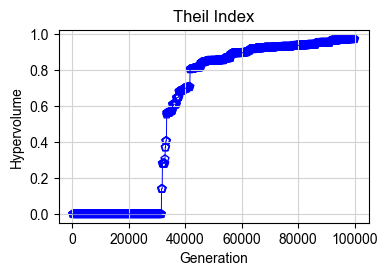

In [41]:
F = res.F
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
metric = Hypervolume(ref_point= np.array([10, 0.1]),
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(4, 2.5))
plt.plot(n_evals, hv,  color='blue', lw=0.7)
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='blue', marker="p")
plt.xlabel("Generation")
plt.ylabel("Hypervolume")
plt.title("Theil Index")
plt.grid(True, color='lightgray')
plt.savefig("convergence_pf_theil.eps", format="eps", bbox_inches='tight')
plt.show()

MOO-relative-range

In [42]:
class MCLPE1(ElementwiseProblem):
    def __init__(self, w, a, p):
        super().__init__(n_var=a.shape[1], n_obj=2, n_ieq_constr=1, xl=0, xu=1, vtype=bool)
        self.w = w
        self.a = a
        self.p = p

    def _evaluate(self, x, out, *args, **kwargs):
        y = np.max(x * self.a, axis=1)

        # Objective 1
        obj1 = np.sum(np.sum(y * self.w.T, axis=1))

        # # Objective 2
        u_k = np.sum(y * self.w.T, axis=1) / np.sum(self.w, axis=0)
        u_bar = np.mean(u_k)
        obj2 = (np.max(u_k) - np.min(u_k)) / u_bar

        constr = np.sum(x) - self.p  # Constraint on the total number of facilities

        out["F"] = [-obj1, obj2]
        out["G"] = [constr]

problem = MCLPE1(W, A, p)

algorithm = NSGA2(
    pop_size=100,
    sampling=BinaryRandomSampling(),
    crossover=TwoPointCrossover(),
    mutation=BitflipMutation(),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 1000)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  5.160000E+02 |  5.641100E+02 |             - |             -
     2 |      200 |      1 |  5.100000E+02 |  5.424300E+02 |             - |             -
     3 |      300 |      1 |  5.060000E+02 |  5.305400E+02 |             - |             -
     4 |      400 |      1 |  5.010000E+02 |  5.212900E+02 |             - |             -
     5 |      500 |      1 |  4.880000E+02 |  5.116500E+02 |             - |             -
     6 |      600 |      1 |  4.840000E+02 |  5.026400E+02 |             - |             -
     7 |      700 |      1 |  4.780000E+02 |  4.946500E+02 |             - |             -
     8 |      800 |      1 |  4.720000E+02 |  4.876100E+02 |             - |             -
     9 |      900 |      1 |  4.630000E+02 |  4.811700E+02 |             - |             -
    10 |     1000 |      1 |  4.630000E+02 |  4.754000E+02 |             - |             -

AttributeError: 'numpy.ndarray' object has no attribute 'append'

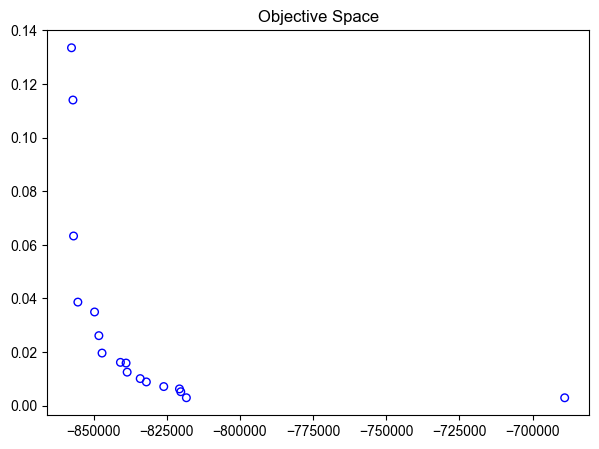

In [43]:
F = res.F
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

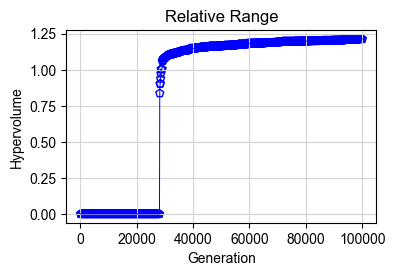

In [48]:
F = res.F
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
metric = Hypervolume(ref_point= np.array([10, 0.1]),
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(4, 2.5))
plt.plot(n_evals, hv,  color='blue', lw=0.7)
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='blue', marker="p")
plt.xlabel("Generation")
plt.ylabel("Hypervolume")
plt.title("Relative Range")
plt.grid(True, color='lightgray')
plt.savefig("convergence_pf_rr.eps", format="eps", bbox_inches='tight')
plt.show()

MOO-variance

In [49]:
class MCLPE2(ElementwiseProblem):
    def __init__(self, w, a, p):
        super().__init__(n_var=a.shape[1], n_obj=2, n_ieq_constr=1, xl=0, xu=1, vtype=bool)
        self.w = w
        self.a = a
        self.p = p

    def _evaluate(self, x, out, *args, **kwargs):
        y = np.max(x * self.a, axis=1)

        # Objective 1
        obj1 = np.sum(np.sum(y * self.w.T, axis=1))

        # # Objective 2
        u_k = np.sum(y * self.w.T, axis=1) / np.sum(self.w, axis=0)
        obj2 = np.var(u_k)

        constr = np.sum(x) - self.p  # Constraint on the total number of facilities

        out["F"] = [-obj1, obj2]
        out["G"] = [constr]

problem = MCLPE2(W, A, p)

algorithm = NSGA2(
    pop_size=100,
    sampling=BinaryRandomSampling(),
    crossover=TwoPointCrossover(),
    mutation=BitflipMutation(),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 1000)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  5.160000E+02 |  5.641100E+02 |             - |             -
     2 |      200 |      1 |  5.100000E+02 |  5.424300E+02 |             - |             -
     3 |      300 |      1 |  5.060000E+02 |  5.305400E+02 |             - |             -
     4 |      400 |      1 |  5.010000E+02 |  5.212900E+02 |             - |             -
     5 |      500 |      1 |  4.880000E+02 |  5.116500E+02 |             - |             -
     6 |      600 |      1 |  4.840000E+02 |  5.026400E+02 |             - |             -
     7 |      700 |      1 |  4.780000E+02 |  4.946500E+02 |             - |             -
     8 |      800 |      1 |  4.720000E+02 |  4.876100E+02 |             - |             -
     9 |      900 |      1 |  4.630000E+02 |  4.811700E+02 |             - |             -
    10 |     1000 |      1 |  4.630000E+02 |  4.754000E+02 |             - |             -

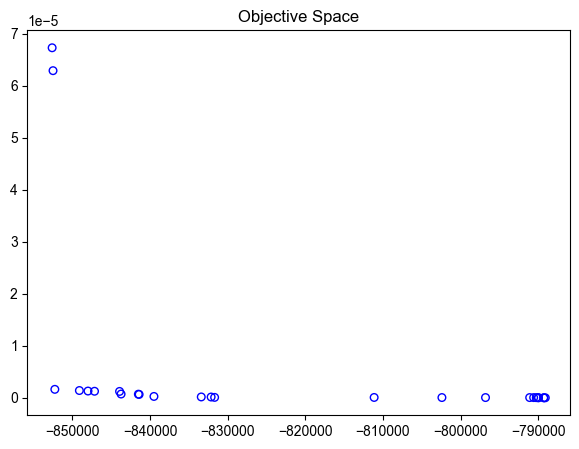

In [50]:
F = res.F
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

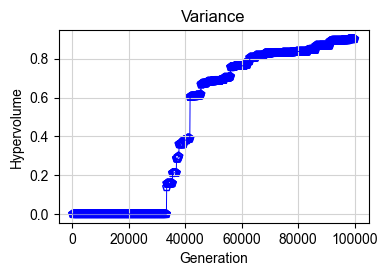

In [51]:
F = res.F
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
metric = Hypervolume(ref_point= np.array([10, 0.1]),
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(4, 2.5))
plt.plot(n_evals, hv,  color='blue', lw=0.7)
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='blue', marker="p")
plt.xlabel("Generation")
plt.ylabel("Hypervolume")
plt.title("Variance")
plt.grid(True, color='lightgray')
plt.savefig("convergence_pf_var.eps", format="eps", bbox_inches='tight')
plt.show()